<a href="https://colab.research.google.com/github/Bryan0122/PRI/blob/master/Copia_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cargar base de datos sinteticas
#https://drive.google.com/file/d/17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB/view?usp=sharing
#id del archivo: 17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB

FILEID = "17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir
!pip install mne==0.19

--2020-08-11 22:00:24--  https://docs.google.com/uc?export=download&confirm=&id=17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB
Resolving docs.google.com (docs.google.com)... 74.125.20.102, 74.125.20.138, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-4k-docs.googleusercontent.com/docs/securesc/050jpq585jg83d12o7sclf4cbel43jf7/fis23hgqs37sfe0s9j5j09mlo49qbsb6/1597183200000/11146100322577758036/08043026367517388758Z/17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB?e=download [following]
--2020-08-11 22:00:25--  https://doc-0c-4k-docs.googleusercontent.com/docs/securesc/050jpq585jg83d12o7sclf4cbel43jf7/fis23hgqs37sfe0s9j5j09mlo49qbsb6/1597183200000/11146100322577758036/08043026367517388758Z/17lVU6fkPARDwRSThDR4LCIw5AvdkoIRB?e=download
Resolving doc-0c-4k-docs.googleusercontent.com (doc-0c-4k-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0

In [1]:
import os
import sys
Path='/content/CKAPRI'
sys.path.append(Path)
DB = os.path.join(Path, 'DB')

In [2]:
!pip install tf-nightly
import numpy as np
import scipy.io as sio
from CKA_PRI import *
import tensorflow as tf
from joblib import dump,load
from sklearn import  datasets
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score,jaccard_score

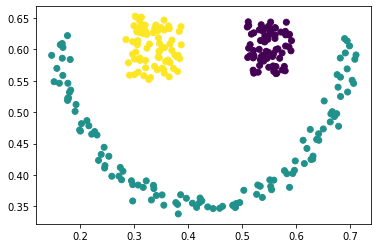

In [3]:
data = sio.loadmat(DB)['DB'][0, 0]
happy = data['happy']
sc = SpectralClustering(n_clusters=3, n_neighbors=5, gamma = 1000)
sc.fit(happy)
labels_happy = sc.labels_
plt.scatter(happy[:,0],happy[:,1],c=labels_happy)

In [4]:
ind = np.argsort(labels_happy)
Xtrain = happy[ind]
ytrain = labels_happy[ind]

In [5]:
def custom_loss_itl( scalex=1, lanbda=0.5, scaley=1):
    # @tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_kitl(y_true, y_pred):  # ytrue labels, ypred  = Xw
        #kernels###############################################
        #scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
        #    amplitude=1, length_scale=scalex)
        scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=1, length_scale=scaley)
        # si devuelve z, matmul(z,z)
        #k = scalar_kernel.matrix(y_pred, y_pred)
        #k = tf.matmul(y_pred, y_pred,transpose_b=True)
        k=y_pred
        l = scalar_kernely.matrix(y_true, y_true)
        #centralizar#####################################################
        N = tf.cast(tf.shape(l)[0], dtype=tf.float32)
        # matrix for centered kernel
        h = tf.eye(N) - (1.0 / N) * tf.ones([N, 1]) * tf.ones([1, N])
        # F inicial ####################################################
        trkl = (1.0 / N**2) * \
            tf.linalg.trace(tf.matmul(tf.matmul(k, h), tf.matmul(l, h)))
        trkk = (1.0 / N**2) * \
            tf.linalg.trace(tf.matmul(tf.matmul(k, h), tf.matmul(k, h)))
        #trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
        f = -(1 - lanbda) * tf.math.log(trkl) + 0.5 * \
            lanbda * tf.math.log(trkk)  # funcion de costo
        return f
    # Return a function
    return custom_kitl

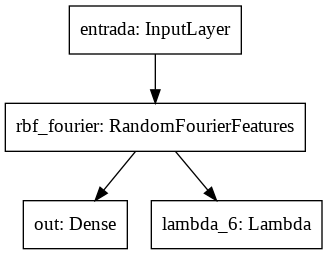

In [12]:
D=150
seed=100
sigmay=0.1
sigmax=1
lambda_=0.5
bs=64
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1]), name='entrada')
h1 = tf.keras.layers.experimental.RandomFourierFeatures(output_dim=D,scale=sigmay, kernel_initializer='gaussian', trainable= False, name='rbf_fourier')(input_l)
def norcka(K):
  aux=tf.matmul(K,K,transpose_b=True)
  aux=aux-tf.math.reduce_min(aux)
  aux=aux/tf.math.reduce_max(aux)
  return aux # tensores
kl=tf.keras.layers.Lambda(norcka,output_shape=bs,input_dim=D)(h1)
#kl=tf.keras.activations.linear(kl)
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1, seed=seed)
output = tf.keras.layers.Dense(3, activation='softmax', name='out', kernel_initializer=initializer,input_dim=bs)(h1)
#outputC = tf.keras.layers.Dense(3,activation="linear",use_bias=False,kernel_regularizer=initializer,name='outC_cka')(h1) #salida rotacion Lineal con cka
model = tf.keras.Model(inputs=input_l, outputs=[output,kl])
# model.summary()



tf.keras.utils.plot_model(model)
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures              

In [13]:
model.compile(loss=[custom_loss_itl(scalex=sigmax, lanbda=lambda_, scaley=sigmay),custom_loss_itl(scalex=sigmax, lanbda=lambda_, scaley=sigmay)],
               loss_weights = [0.8,0.2], 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),)  # f1, precision, re
tf.keras.utils.plot_model(model)
history = model.fit(Xtrain, [Xtrain,Xtrain], epochs=100, batch_size=bs,  # 32, 64, 128, 256
                    validation_split=0)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

Epoch 1/100


InvalidArgumentError: ignored

In [89]:
[p,K]=model.predict(Xtrain)

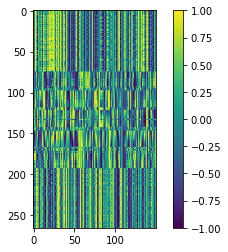

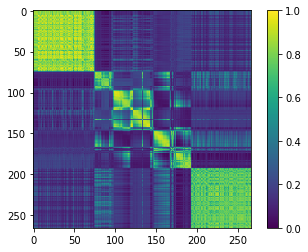

In [95]:
scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=1, length_scale=1)
ke = scalar_kernel.matrix(K, K)
plt.imshow(K)
plt.colorbar()
plt.show()
auxK=K.dot(K.T)
auxK=auxK-np.amin(auxK)
auxK=auxK/np.amax(auxK)
plt.imshow(auxK)
plt.colorbar()

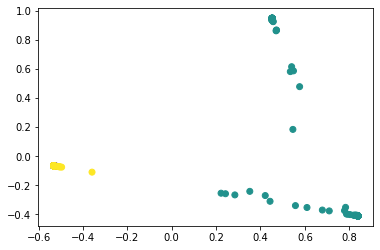

In [91]:
red = PCA(n_components=2)
zr = red.fit_transform(p)
plt.scatter(zr[:,0],zr[:,1],c=ytrain)

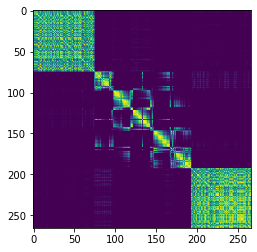

In [92]:
scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=1, length_scale=0.05)
ko = scalar_kernel.matrix(Xtrain, Xtrain)
plt.imshow(ko)

Ari: 0.27533511624910073 y accuracy: 0.37593984962406013


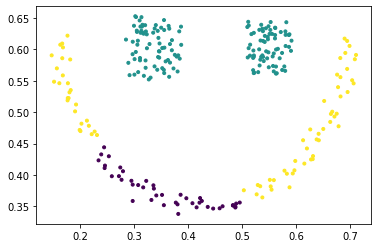

In [93]:
labels_pre_=np.argmax(p,axis=1)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=labels_pre_, marker='.')
Rari_=adjusted_rand_score(labels_happy,labels_pre_)
Racc_=accuracy_score(labels_happy,labels_pre_)
print('Ari: '+str(Rari_)+' y'+' accuracy: '+str(Racc_))